In [1]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
# Adavnced model training
#from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization, Attention, MultiHeadAttention, LayerNormalization
#
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from comprehensive_model_analysis import comprehensive_model_analysis

In [2]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the credit risk dataset
    """
    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path)
    
    print(f"Original dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Remove LoanID as it's just an identifier
    if 'LoanID' in df.columns:
        df = df.drop('LoanID', axis=1)
    
    # Handle missing values
    print(f"Missing values per column:")
    print(df.isnull().sum())
    
    # Fill missing values (you may need to adjust this based on your data)
    df = df.fillna(df.median(numeric_only=True))  # Fill numeric columns with median
    df = df.fillna(df.mode().iloc[0])  # Fill categorical columns with mode
    
    # Separate features and target
    X = df.drop('Default', axis=1)
    y = df['Default']
    
    # Encode categorical variables
    categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 
                          'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
    
    # Create label encoders for categorical variables
    label_encoders = {}
    for col in categorical_columns:
        if col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
    
    # Ensure all columns are numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    
    print(f"Processed features shape: {X.shape}")
    print(f"Feature names: {list(X.columns)}")
    print(f"Default rate: {np.mean(y):.1%}")
    
    return X, y, list(X.columns), df, label_encoders


In [3]:
# Custom callback to optimize for business metrics during training
class BusinessMetricCallback(Callback):
    def __init__(self, X_val, y_val, revenue_per_good, loss_per_default, patience=10):
        self.X_val = X_val
        self.y_val = y_val
        self.revenue_per_good = revenue_per_good
        self.loss_per_default = loss_per_default
        self.patience = patience
        self.best_profit = -np.inf
        self.wait = 0
        self.best_weights = None
        
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions
        if isinstance(self.X_val, list):  # Meta-learning model
            y_pred = self.model.predict(self.X_val, verbose=0)
        else:  # Monolithic model
            y_pred = self.model.predict(self.X_val, verbose=0)
        
        # Find optimal threshold for current epoch
        best_threshold, _ = find_optimal_threshold_business(
            self.y_val, y_pred, self.revenue_per_good, self.loss_per_default
        )
        
        current_profit = best_threshold['profit']
        
        if current_profit > self.best_profit:
            self.best_profit = current_profit
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            
        if self.wait >= self.patience:
            self.model.stop_training = True
            if self.best_weights is not None:
                self.model.set_weights(self.best_weights)

In [4]:
def find_optimal_threshold_business(y_true, y_prob, revenue_per_good, loss_per_default):
    """Optimized threshold finding for business metrics"""
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).ravel()
    
    # Use quantile-based thresholds for better coverage
    thresholds = np.quantile(y_prob, np.linspace(0.05, 0.95, 30))
    
    best_profit = -np.inf
    best_result = None
    all_results = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))
        
        # Business profit calculation
        profit = tn * revenue_per_good - fn * loss_per_default - fp * revenue_per_good
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tn + tp) / (tn + fp + fn + tp)
        
        result = {
            'threshold': threshold,
            'profit': profit,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy,
            'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)
        }
        
        all_results.append(result)
        
        if profit > best_profit:
            best_profit = profit
            best_result = result
    
    return best_result, all_results

In [5]:
# Helper function (you'll need to import this from your existing code)
def find_optimal_threshold_business_with_adv_training(y_true, y_prob, revenue_per_good, loss_per_default):
    """Find optimal business threshold"""
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).ravel()
    
    thresholds = np.quantile(y_prob, np.linspace(0.05, 0.95, 50))
    
    best_profit = -np.inf
    best_result = None
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))
        
        profit = tn * revenue_per_good - fn * loss_per_default - fp * revenue_per_good
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tn + tp) / (tn + fp + fn + tp)
        
        result = {
            'threshold': threshold,
            'profit': profit,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy,
            'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)
        }
        
        if profit > best_profit:
            best_profit = profit
            best_result = result
    
    return best_result, []

In [6]:
def create_improved_meta_learning_model(financial_dim, behavioral_dim, use_business_loss=True):
    """
    Create an improved meta-learning model with better architecture
    """
    # Specialized financial risk assessment branch
    financial_input = Input(shape=(financial_dim,), name='financial_input')
    x1 = Dense(128, activation='relu')(financial_input)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(64, activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.2)(x1)
    financial_features = Dense(32, activation='relu', name='financial_risk')(x1)
    
    # Specialized behavioral pattern analysis branch
    behavioral_input = Input(shape=(behavioral_dim,), name='behavioral_input')
    x2 = Dense(64, activation='relu')(behavioral_input)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)
    x2 = Dense(32, activation='relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.2)(x2)
    behavioral_features = Dense(16, activation='relu', name='behavioral_patterns')(x2)
    
    # Advanced feature interaction layer
    combined = Concatenate(name='feature_fusion')([financial_features, behavioral_features])
    
    # Meta-learner with attention-like mechanism
    z = Dense(64, activation='relu')(combined)
    z = BatchNormalization()(z)
    z = Dropout(0.3)(z)
    
    # Risk assessment layers
    z = Dense(32, activation='relu')(z)
    z = Dropout(0.2)(z)
    z = Dense(16, activation='relu')(z)
    
    # Final risk prediction
    risk_output = Dense(1, activation='sigmoid', name='default_probability')(z)
    
    model = Model(
        inputs=[financial_input, behavioral_input],
        outputs=risk_output,
        name='improved_meta_learning_model'
    )
    
    # Custom loss function that incorporates business cost
    if use_business_loss:
        def business_weighted_loss(y_true, y_pred):
            # Standard binary crossentropy
            bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
            
            # Business cost weighting
            # Penalize false negatives (missed defaults) more heavily
            fn_penalty = y_true * (1 - y_pred) * 6.3  # loss_per_default / revenue_per_good
            fp_penalty = (1 - y_true) * y_pred * 1.0  # opportunity cost
            
            return bce + fn_penalty + fp_penalty
        
        loss_function = business_weighted_loss
    else:
        loss_function = 'binary_crossentropy'
    
    model.compile(
        optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=loss_function,
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

In [7]:
def create_enhanced_monolithic_model(input_dim, use_business_loss=True):
    """Enhanced monolithic model for fair comparison"""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    
    # Same business loss as meta-learning model
    if use_business_loss:
        def business_weighted_loss(y_true, y_pred):
            bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
            fn_penalty = y_true * (1 - y_pred) * 6.3
            fp_penalty = (1 - y_true) * y_pred * 1.0
            return bce + fn_penalty + fp_penalty
        
        loss_function = business_weighted_loss
    else:
        loss_function = 'binary_crossentropy'
    
    model.compile(
        optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=loss_function,
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

In [8]:
def improved_feature_engineering(X, feature_names):
    """Better feature separation for meta-learning"""
    
    # Core financial risk indicators (quantitative)
    financial_features = [
        'CreditScore', 'DTIRatio', 'LoanAmount', 'InterestRate', 
        'Income', 'LoanTerm', 'LoanPurpose','HasCoSigner'
    ]
    
    # Behavioral and contextual indicators (mixed)
    behavioral_features = [
        'NumCreditLines', 'Education', 'EmploymentType', 'MaritalStatus',
        'HasMortgage', 'HasDependents', 'Age', 'MonthsEmployed'
    ]
    
    # Create interaction features for meta-learning
    X_enhanced = X.copy()
    
    # Add some engineered features that might help meta-learning
    if 'CreditScore' in X.columns and 'DTIRatio' in X.columns:
        X_enhanced['CreditScore_DTI_Ratio'] = X['CreditScore'] / (X['DTIRatio'] + 0.01)
    
    if 'Income' in X.columns and 'LoanAmount' in X.columns:
        X_enhanced['Income_to_Loan_Ratio'] = X['Income'] / (X['LoanAmount'] + 0.01)
    
    if 'Age' in X.columns and 'MonthsEmployed' in X.columns:
        X_enhanced['Employment_Stability'] = X['MonthsEmployed'] / (X['Age'] + 0.01)
    
    # Get indices for enhanced feature set
    enhanced_feature_names = list(X_enhanced.columns)
    
    financial_indices = [i for i, name in enumerate(enhanced_feature_names) 
                        if any(fin_feat in name for fin_feat in financial_features)]
    behavioral_indices = [i for i, name in enumerate(enhanced_feature_names) 
                         if any(beh_feat in name for beh_feat in behavioral_features)]
    
    return X_enhanced, financial_indices, behavioral_indices, enhanced_feature_names

In [9]:
def train_with_business_optimization(model, X_train, y_train, X_val, y_val, 
                                   revenue_per_good, loss_per_default, 
                                   class_weights, epochs=150):
    """Train model with business metric optimization"""
    
    # Business-focused callback
    business_callback = BusinessMetricCallback(
        X_val, y_val, revenue_per_good, loss_per_default, patience=15
    )
    
    # Early stopping on validation loss as backup
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True, verbose=0
    )
    
    # Reduced learning rate on plateau
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=0
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=128,  # Larger batch size for stability
        class_weight=class_weights,
        callbacks=[business_callback, early_stopping, reduce_lr],
        verbose=1
    )
    
    return history



In [10]:
def plot_chart(mono_history, mono_pred, meta_history, meta_pred, threshold_results):
    # Plot training histories and threshold analysis
    plt.figure(figsize=(20, 10))
    
    # Training history plots
    plt.subplot(2, 4, 1)
    plt.plot(mono_history.history['accuracy'], label='Monolithic Train')
    plt.plot(mono_history.history['val_accuracy'], label='Monolithic Val')
    plt.plot(meta_history.history['accuracy'], label='Meta-Learning Train')
    plt.plot(meta_history.history['val_accuracy'], label='Meta-Learning Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 4, 2)
    plt.plot(mono_history.history['loss'], label='Monolithic Train')
    plt.plot(mono_history.history['val_loss'], label='Monolithic Val')
    plt.plot(meta_history.history['loss'], label='Meta-Learning Train')
    plt.plot(meta_history.history['val_loss'], label='Meta-Learning Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 4, 3)
    plt.hist(mono_pred, alpha=0.7, label='Monolithic', bins=20)
    plt.hist(meta_pred, alpha=0.7, label='Meta-Learning', bins=20)
    plt.title('Prediction Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    # Threshold analysis plots
    thresholds_plot = [r['threshold'] for r in threshold_results]
    accuracies = [r['accuracy'] for r in threshold_results]
    precisions = [r['precision'] for r in threshold_results]
    recalls = [r['recall'] for r in threshold_results]
    f1_scores = [r['f1'] for r in threshold_results]
    false_alarms = [r['false_alarms'] for r in threshold_results]
    
    plt.subplot(2, 4, 4)
    plt.plot(thresholds_plot, accuracies, 'o-', label='Accuracy')
    plt.plot(thresholds_plot, precisions, 's-', label='Precision')
    plt.plot(thresholds_plot, recalls, '^-', label='Recall')
    plt.plot(thresholds_plot, f1_scores, 'd-', label='F1-Score')
    plt.axvline(x=business_optimal['threshold'], color='red', linestyle='--', alpha=0.7, label='Business Optimal')
    plt.title('Metrics vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 4, 5)
    plt.plot(thresholds_plot, false_alarms, 'ro-')
    plt.axvline(x=business_optimal['threshold'], color='red', linestyle='--', alpha=0.7, label='Business Optimal')
    plt.title('False Alarms vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Number of False Alarms')
    plt.legend()
    plt.grid(True)
    
    # Precision-Recall tradeoff
    plt.subplot(2, 4, 6)
    plt.plot(recalls, precisions, 'bo-')
    for i, thresh in enumerate(thresholds_plot):
        plt.annotate(f'{thresh:.1f}', (recalls[i], precisions[i]), 
                    textcoords="offset points", xytext=(5,5), ha='left')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Tradeoff')
    plt.grid(True)
    
    # ROC-like curve showing recall vs false alarm rate
    plt.subplot(2, 4, 7)
    total_negatives = np.sum(data['meta_learning']['y_test'] == 0)
    false_alarm_rates = [fa / total_negatives for fa in false_alarms]
    plt.plot(false_alarm_rates, recalls, 'go-')
    for i, thresh in enumerate(thresholds_plot):
        plt.annotate(f'{thresh:.1f}', (false_alarm_rates[i], recalls[i]), 
                    textcoords="offset points", xytext=(5,5), ha='left')
    plt.xlabel('False Alarm Rate')
    plt.ylabel('Recall (True Positive Rate)')
    plt.title('Recall vs False Alarm Rate')
    plt.grid(True)
    
    # Business impact visualization
    plt.subplot(2, 4, 8)
    total_defaults = np.sum(data['meta_learning']['y_test'] == 1)
    caught_defaults = [recall * total_defaults for recall in recalls]
    missed_defaults = [total_defaults - caught for caught in caught_defaults]
    
    plt.bar(range(len(thresholds_plot)), caught_defaults, alpha=0.7, label='Caught Defaults', color='green')
    plt.bar(range(len(thresholds_plot)), missed_defaults, bottom=caught_defaults, alpha=0.7, label='Missed Defaults', color='red')
    plt.axvline(x=thresholds_plot.index(business_optimal['threshold']), color='blue', linestyle='--', alpha=0.7, label='Business Optimal')
    plt.xlabel('Threshold Index')
    plt.ylabel('Number of Defaults')
    plt.title('Defaults: Caught vs Missed')
    plt.xticks(range(len(thresholds_plot)), [f'{t:.1f}' for t in thresholds_plot])
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    return

In [11]:
# Example usage integration with your existing code:
def enhanced_train_and_evaluate_models(file_path, revenue_per_good=14250.0, loss_per_default=90000.0):
    """Enhanced version of your training function"""
    print("=" * 80)
    print("ENHANCED MONOLITHIC vs META-LEARNING MODEL COMPARISON")
    print("=" * 80)
    
    # Load and preprocess data (using your existing function)
#    from your_existing_code import load_and_preprocess_data  # Import your function
    X, y, feature_names, df, label_encoders = load_and_preprocess_data(file_path)

    # Enhanced feature engineering
    X_enhanced, financial_indices, behavioral_indices, enhanced_feature_names = improved_feature_engineering(X, feature_names)
    
    # Prepare data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_enhanced, y, test_size=0.4, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples") 
    print(f"Test set: {len(X_test)} samples")
    print(f"Default rate: {np.mean(y)*100:.1f}%")
    
    # Create models
    print("\n1. Creating Enhanced Models...")
    monolithic_model = create_enhanced_monolithic_model(X_enhanced.shape[1], use_business_loss=True)
    
    financial_dim = len(financial_indices)
    behavioral_dim = len(behavioral_indices)
    meta_model = create_improved_meta_learning_model(financial_dim, behavioral_dim, use_business_loss=True)
    
    print(f"Financial features ({financial_dim}): {[enhanced_feature_names[i] for i in financial_indices[:5]]}...")
    print(f"Behavioral features ({behavioral_dim}): {[enhanced_feature_names[i] for i in behavioral_indices[:5]]}...")
    
    # Prepare validation data for meta-learning
    X_val_financial = X_val_scaled[:, financial_indices]
    X_val_behavioral = X_val_scaled[:, behavioral_indices]
    X_test_financial = X_test_scaled[:, financial_indices]
    X_test_behavioral = X_test_scaled[:, behavioral_indices]
    
    # Train models with business optimization
    print("\n2. Training Monolithic Model with Business Optimization...")
    mono_history = train_with_business_optimization(
        monolithic_model, X_train_scaled, y_train, X_val_scaled, y_val,
        revenue_per_good, loss_per_default, class_weight_dict
    )
    
    print("\n3. Training Meta-Learning Model with Business Optimization...")
    meta_history = train_with_business_optimization(
        meta_model, [X_train_scaled[:, financial_indices], X_train_scaled[:, behavioral_indices]], 
        y_train, [X_val_financial, X_val_behavioral], y_val,
        revenue_per_good, loss_per_default, class_weight_dict
    )
    
    # Final evaluation with optimal thresholds
    print("\n4. Final Evaluation with Business-Optimal Thresholds...")
    
    # Get predictions
    mono_pred = monolithic_model.predict(X_test_scaled, verbose=0)
    meta_pred = meta_model.predict([X_test_financial, X_test_behavioral], verbose=0)
    
    # Find optimal thresholds
    best_mono, mono_grid = find_optimal_threshold_business_with_adv_training(y_test, mono_pred, revenue_per_good, loss_per_default)
    best_meta, meta_grid = find_optimal_threshold_business_with_adv_training(y_test, meta_pred, revenue_per_good, loss_per_default)
    
    # Apply optimal thresholds
    mono_pred_optimal = (mono_pred >= best_mono['threshold']).astype(int)
    meta_pred_optimal = (meta_pred >= best_meta['threshold']).astype(int)
    
    print("\nBUSINESS-OPTIMIZED RESULTS:")
    print("=" * 50)
    print(f"Monolithic - Threshold: {best_mono['threshold']:.3f}, Profit: ${best_mono['profit']:,.0f}")
    print(f"Meta-Learning - Threshold: {best_meta['threshold']:.3f}, Profit: ${best_meta['profit']:,.0f}")
    print(f"Profit Improvement: ${best_meta['profit'] - best_mono['profit']:,.0f}")
    
    print(f"\nMonolithic Model (Optimal Threshold):")
    print(classification_report(y_test, mono_pred_optimal, target_names=['No Default', 'Default']))
    
    print(f"\nMeta-Learning Model (Optimal Threshold):")
    print(classification_report(y_test, meta_pred_optimal, target_names=['No Default', 'Default']))

    plot_chart(mono_history, mono_pred, meta_history, meta_pred, meta_grid)
    
    return {
        'monolithic_model': monolithic_model,
        'meta_model': meta_model,
        'optimal_thresholds': {'monolithic': best_mono, 'meta_learning': best_meta},
        'predictions': {
            'monolithic': {'probabilities': mono_pred, 'binary': mono_pred_optimal},
            'meta_learning': {'probabilities': meta_pred, 'binary': meta_pred_optimal}
        },
        'histories': {'monolithic': mono_history, 'meta_learning': meta_history}
    }

In [12]:
# Strategy 1: Risk-Based Feature Engineering
def create_risk_based_features(df):
    """Create risk-specific engineered features"""
    df_new = df.copy()
    
    # Credit utilization patterns
    if 'CreditScore' in df.columns and 'NumCreditLines' in df.columns:
        df_new['CreditScore_per_Line'] = df['CreditScore'] / (df['NumCreditLines'] + 1)
        
    # Debt service ratios
    if 'Income' in df.columns and 'LoanAmount' in df.columns and 'InterestRate' in df.columns and 'LoanTerm' in df.columns:
        # Monthly payment estimation
        monthly_rate = df['InterestRate'] / 100 / 12
        monthly_payment = df['LoanAmount'] * (monthly_rate * (1 + monthly_rate)**df['LoanTerm']) / ((1 + monthly_rate)**df['LoanTerm'] - 1)
        df_new['Monthly_Payment'] = monthly_payment
        df_new['Payment_to_Income_Ratio'] = monthly_payment / (df['Income'] / 12 + 0.01)
        
    # Employment stability indicators
    if 'Age' in df.columns and 'MonthsEmployed' in df.columns:
        df_new['Employment_Stability_Ratio'] = df['MonthsEmployed'] / (df['Age'] * 12 + 0.01)
        df_new['Years_Employed'] = df['MonthsEmployed'] / 12
        
    # Risk concentration features
    if 'LoanAmount' in df.columns and 'Income' in df.columns:
        df_new['Loan_to_Income_Ratio'] = df['LoanAmount'] / (df['Income'] + 0.01)
        
    # Demographic risk factors
    if 'Age' in df.columns:
        df_new['Age_Risk_Bucket'] = pd.cut(df['Age'], bins=[0, 25, 35, 50, 65, 100], labels=[0, 1, 2, 3, 4])
        
    # Combine multiple risk factors
    if all(col in df.columns for col in ['CreditScore', 'DTIRatio', 'Income']):
        # Normalized risk score
        df_new['Combined_Risk_Score'] = (
            (800 - df['CreditScore']) / 300 +  # Higher credit score = lower risk
            df['DTIRatio'] +  # Higher DTI = higher risk
            1 / (df['Income'] / 50000 + 0.1)  # Lower income = higher risk
        ) / 3
        
    return df_new

# Strategy 2: Attention-Based Meta-Learning Architecture
def create_attention_meta_model(financial_dim, behavioral_dim, use_advanced_fusion=True):
    """Create meta-learning model with attention mechanisms"""
    
    # Enhanced financial risk branch
    financial_input = Input(shape=(financial_dim,), name='financial_input')
    f1 = Dense(256, activation='relu')(financial_input)
    f1 = BatchNormalization()(f1)
    f1 = Dropout(0.3)(f1)
    f1 = Dense(128, activation='relu')(f1)
    f1 = BatchNormalization()(f1)
    f1 = Dropout(0.2)(f1)
    financial_features = Dense(64, activation='relu', name='financial_embedding')(f1)
    
    # Enhanced behavioral pattern branch
    behavioral_input = Input(shape=(behavioral_dim,), name='behavioral_input')
    b1 = Dense(128, activation='relu')(behavioral_input)
    b1 = BatchNormalization()(b1)
    b1 = Dropout(0.3)(b1)
    b1 = Dense(64, activation='relu')(b1)
    b1 = BatchNormalization()(b1)
    b1 = Dropout(0.2)(b1)
    behavioral_features = Dense(32, activation='relu', name='behavioral_embedding')(b1)
    
    if use_advanced_fusion:
        # Cross-attention mechanism using Keras layers
        from tensorflow.keras.layers import Reshape, Lambda
        
        # Reshape for attention (add sequence dimension) using Keras layers
        financial_reshaped = Reshape((1, 64))(financial_features)  # (batch, 1, 64)
        
        # Pad behavioral to match financial dimension for attention
        behavioral_padded = Dense(64)(behavioral_features)
        behavioral_reshaped = Reshape((1, 64))(behavioral_padded)  # (batch, 1, 64)
        
        # Multi-head attention - behavioral attending to financial (layer 1)
        attention_layer1 = MultiHeadAttention(num_heads=4, key_dim=16, name='beh_to_fin_attention')
        behavioral_attended = attention_layer1(behavioral_reshaped, financial_reshaped)
        
        # Multi-head attention - financial attending to behavioral (layer 2)  
        attention_layer2 = MultiHeadAttention(num_heads=4, key_dim=16, name='fin_to_beh_attention')
        financial_attended = attention_layer2(financial_reshaped, behavioral_reshaped)
        
        # Flatten back to 2D using Keras layers
        financial_attended = Reshape((64,))(financial_attended)
        behavioral_attended = Reshape((64,))(behavioral_attended)
        
        # Combine with original features
        financial_final = Concatenate()([financial_features, financial_attended])
        behavioral_final = Concatenate()([behavioral_features, behavioral_attended])
        
        # Final fusion
        combined = Concatenate(name='attention_fusion')([financial_final, behavioral_final])
    else:
        # Simple concatenation
        combined = Concatenate(name='simple_fusion')([financial_features, behavioral_features])
    
    # Advanced meta-learner
    meta = Dense(128, activation='relu')(combined)
    meta = BatchNormalization()(meta)
    meta = Dropout(0.4)(meta)  # Added missing parentheses
    meta = Dense(64, activation='relu')(meta)
    meta = Dropout(0.3)(meta)
    meta = Dense(32, activation='relu')(meta)
    meta = Dropout(0.2)(meta)
    
    # Risk prediction with uncertainty estimation
    risk_logits = Dense(16, activation='relu')(meta)
    risk_output = Dense(1, activation='sigmoid', name='default_probability')(risk_logits)
    
    model = Model(
        inputs=[financial_input, behavioral_input],
        outputs=risk_output,
        name='attention_meta_learning_model'
    )
    
    return model

# Strategy 3: Ensemble Meta-Learning
def create_ensemble_meta_model(financial_dim, behavioral_dim, n_base_models=3):
    """Create an ensemble of specialized meta-learning models"""
    
    financial_input = Input(shape=(financial_dim,), name='financial_input')
    behavioral_input = Input(shape=(behavioral_dim,), name='behavioral_input')
    
    ensemble_outputs = []
    
    for i in range(n_base_models):
        # Each base model has slightly different architecture
        f_hidden = 128 + i * 32  # Varying hidden sizes
        b_hidden = 64 + i * 16
        
        # Financial branch
        f = Dense(f_hidden, activation='relu', name=f'financial_branch_{i}')(financial_input)
        f = BatchNormalization()(f)
        f = Dropout(0.3)(f)
        f_out = Dense(32, activation='relu')(f)
        
        # Behavioral branch  
        b = Dense(b_hidden, activation='relu', name=f'behavioral_branch_{i}')(behavioral_input)
        b = BatchNormalization()(b)
        b = Dropout(0.3)(b)
        b_out = Dense(16, activation='relu')(b)
        
        # Combine and predict
        combined = Concatenate()([f_out, b_out])
        hidden = Dense(64, activation='relu')(combined)
        hidden = Dropout(0.2)(hidden)
        pred = Dense(1, activation='sigmoid', name=f'prediction_{i}')(hidden)
        
        ensemble_outputs.append(pred)
    
    # Meta-combiner learns to weight the ensemble
    if n_base_models > 1:
        ensemble_concat = Concatenate()(ensemble_outputs)
        meta_weights = Dense(n_base_models, activation='softmax')(ensemble_concat)
        
        # Weighted average using Keras layers
        from tensorflow.keras.layers import Lambda
        
        weighted_preds = []
        for i, pred in enumerate(ensemble_outputs):
            # Extract weight for this prediction using Lambda layer
            weight_extractor = Lambda(lambda x: tf.expand_dims(x[:, i], axis=1), 
                                    name=f'weight_extractor_{i}')
            weight = weight_extractor(meta_weights)
            
            # Multiply prediction by weight using Lambda layer
            weighted_pred = Lambda(lambda inputs: inputs[0] * inputs[1], 
                                 name=f'weighted_pred_{i}')([pred, weight])
            weighted_preds.append(weighted_pred)
        
        # Sum weighted predictions using Lambda layer
        final_output = Lambda(lambda preds: tf.reduce_sum(preds, axis=0), 
                            name='ensemble_sum')(weighted_preds)
    else:
        final_output = ensemble_outputs[0]
    
    model = Model(
        inputs=[financial_input, behavioral_input],
        outputs=final_output,
        name='ensemble_meta_learning_model'
    )
    
    return model

# Strategy 4: Risk-Stratified Training
def create_risk_stratified_data(X, y, n_risk_groups=3):
    """Stratify data by risk level for specialized training"""
    
    # Use isolation forest to identify high-risk patterns
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    anomaly_scores = iso_forest.decision_function(X)
    
    # Use clustering to identify risk groups
    kmeans = KMeans(n_clusters=n_risk_groups, random_state=42)
    risk_groups = kmeans.fit_predict(X)
    
    # Combine anomaly scores and clusters for risk stratification
    risk_levels = []
    for i in range(len(X)):
        if anomaly_scores[i] < np.percentile(anomaly_scores, 10):  # High anomaly = high risk
            risk_levels.append(2)  # High risk
        elif risk_groups[i] == np.argmax(np.bincount(risk_groups[y == 1])):  # Cluster with most defaults
            risk_levels.append(1)  # Medium risk
        else:
            risk_levels.append(0)  # Low risk
    
    return np.array(risk_levels)

def create_risk_stratified_meta_model(financial_dim, behavioral_dim, n_risk_strata=3):
    """Meta-model with risk-specific sub-models"""
    
    financial_input = Input(shape=(financial_dim,), name='financial_input')
    behavioral_input = Input(shape=(behavioral_dim,), name='behavioral_input')
    
    # Shared feature extraction
    f_shared = Dense(128, activation='relu')(financial_input)
    f_shared = BatchNormalization()(f_shared)
    f_shared = Dropout(0.3)(f_shared)
    
    b_shared = Dense(64, activation='relu')(behavioral_input)
    b_shared = BatchNormalization()(b_shared)
    b_shared = Dropout(0.3)(b_shared)
    
    combined_shared = Concatenate()([f_shared, b_shared])
    
    # Risk stratification predictor
    risk_classifier = Dense(64, activation='relu')(combined_shared)
    risk_classifier = Dropout(0.2)(risk_classifier)
    risk_probs = Dense(n_risk_strata, activation='softmax', name='risk_stratification')(risk_classifier)
    
    # Risk-specific models
    risk_specific_outputs = []
    for i in range(n_risk_strata):
        risk_model = Dense(64, activation='relu', name=f'risk_model_{i}')(combined_shared)
        risk_model = Dropout(0.2)(risk_model)
        risk_model = Dense(32, activation='relu')(risk_model)
        risk_output = Dense(1, activation='sigmoid', name=f'risk_pred_{i}')(risk_model)
        risk_specific_outputs.append(risk_output)
    
    # Weighted combination based on risk classification
    weighted_outputs = []
    for i, pred in enumerate(risk_specific_outputs):
        weight = tf.expand_dims(risk_probs[:, i], axis=1)
        weighted_outputs.append(pred * weight)
    
    final_output = tf.reduce_sum(weighted_outputs, axis=0)
    
    model = Model(
        inputs=[financial_input, behavioral_input],
        outputs=[final_output, risk_probs],  # Return both prediction and risk stratification
        name='risk_stratified_meta_model'
    )
    
    return model

# Strategy 5: Advanced Business Loss with Calibration
def create_calibrated_business_loss(revenue_per_good, loss_per_default, calibration_strength=0.1):
    """Business loss with probability calibration"""
    def calibrated_business_loss(y_true, y_pred):
        # Standard business loss
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        fn_penalty = y_true * (1 - y_pred) * (loss_per_default / revenue_per_good)
        fp_penalty = (1 - y_true) * y_pred * 1.0
        
        business_loss = bce + fn_penalty + fp_penalty
        
        # Calibration term - penalize overconfident predictions
        confidence_penalty = calibration_strength * (
            tf.square(y_pred - 0.5) * tf.abs(y_true - y_pred)
        )
        
        return business_loss + confidence_penalty
    
    return calibrated_business_loss

# Strategy 6: Comprehensive Training Function
def train_advanced_meta_learning_models(file_path, revenue_per_good=14250.0, loss_per_default=90000.0):
    """Train multiple advanced meta-learning strategies and compare"""
    
    print("=" * 100)
    print("ADVANCED META-LEARNING STRATEGIES COMPARISON")
    print("=" * 100)
    
    # Load and enhance data
    X, y, feature_names, df, label_encoders = load_and_preprocess_data(file_path)  # Your existing function
    
    # Risk-based feature engineering
    df_enhanced = create_risk_based_features(df.drop('Default', axis=1))
    X_enhanced = df_enhanced.select_dtypes(include=[np.number])
    
    print(f"Original features: {len(feature_names)}")
    print(f"Enhanced features: {X_enhanced.shape[1]}")
    print(f"New features added: {X_enhanced.shape[1] - len(feature_names)}")
    
    # Better feature separation for enhanced dataset
    financial_keywords = ['CreditScore', 'DTI', 'Loan', 'Interest', 'Income', 'Payment', 'Age', 'Employment', 'Risk_Score']
    behavioral_keywords = ['Education', 'Employment', 'Marital', 'Mortgage', 'Dependents', 'Purpose', 'CoSigner', 'Credit_Lines']
    
    enhanced_feature_names = list(X_enhanced.columns)
    financial_indices = [i for i, name in enumerate(enhanced_feature_names) 
                        if any(keyword in name for keyword in financial_keywords)]
    behavioral_indices = [i for i, name in enumerate(enhanced_feature_names) 
                         if any(keyword in name for keyword in behavioral_keywords)]
    
    print(f"Financial features: {len(financial_indices)}")
    print(f"Behavioral features: {len(behavioral_indices)}")
    
    # Data splitting
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_enhanced, y, test_size=0.4, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    
    # Create multiple models to test
    models_to_test = {
        'attention_meta': create_attention_meta_model(len(financial_indices), len(behavioral_indices), True),
        'ensemble_meta': create_ensemble_meta_model(len(financial_indices), len(behavioral_indices), 3),
        'simple_meta': create_attention_meta_model(len(financial_indices), len(behavioral_indices), False),
    }
    
    results = {}
    
    for model_name, model in models_to_test.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name.upper()}")
        print(f"{'='*50}")
        
        # Compile with advanced loss
        model.compile(
            optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
            loss=create_calibrated_business_loss(revenue_per_good, loss_per_default, 0.1),
            metrics=['accuracy', 'precision', 'recall']
        )
        
        # Prepare data
        train_data = [X_train_scaled[:, financial_indices], X_train_scaled[:, behavioral_indices]]
        val_data = [X_val_scaled[:, financial_indices], X_val_scaled[:, behavioral_indices]]
        test_data = [X_test_scaled[:, financial_indices], X_test_scaled[:, behavioral_indices]]
        
        # Training callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
        ]
        
        # Train
        history = model.fit(
            train_data, y_train,
            validation_data=(val_data, y_val),
            epochs=100,
            batch_size=256,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate
        test_pred = model.predict(test_data, verbose=0)
        if isinstance(test_pred, list):  # For models with multiple outputs
            test_pred = test_pred[0]
            
        # Find optimal threshold
        best_threshold, _ = find_optimal_threshold_business(y_test, test_pred, revenue_per_good, loss_per_default)
        
        # Final predictions
        final_pred = (test_pred >= best_threshold['threshold']).astype(int)
        
        results[model_name] = {
            'model': model,
            'history': history,
            'threshold': best_threshold,
            'predictions': {'probabilities': test_pred, 'binary': final_pred},
            'profit': best_threshold['profit']
        }
        
        print(f"{model_name} - Threshold: {best_threshold['threshold']:.3f}, Profit: ${best_threshold['profit']:,.0f}")
    
    # Compare results
    print(f"\n{'='*80}")
    print("FINAL COMPARISON")
    print(f"{'='*80}")
    
    best_model_name = max(results.keys(), key=lambda x: results[x]['profit'])
    best_profit = results[best_model_name]['profit']
    
    print(f"Model Performance Ranking:")
    for i, (name, result) in enumerate(sorted(results.items(), key=lambda x: x[1]['profit'], reverse=True), 1):
        profit_diff = result['profit'] - min(r['profit'] for r in results.values())
        print(f"{i}. {name}: ${result['profit']:,.0f} (+${profit_diff:,.0f})")
        
        # Classification report for best model
        if name == best_model_name:
            print(f"\nBest Model ({name}) Classification Report:")
            print(classification_report(y_test, result['predictions']['binary'], 
                                      target_names=['No Default', 'Default']))
    
    return results, y_test


In [13]:
if __name__ == "__main__":
    # Update this path to your CSV file
    file_path = "/Users/peekay/Downloads/Loan_default.csv"  # Change this to your actual file path.  Download from here: https://www.kaggle.com/datasets/nikhil1e9/loan-default/data
    # results = enhanced_train_and_evaluate_models(file_path)
    results, y_test = train_advanced_meta_learning_models(file_path, revenue_per_good=14250.0, loss_per_default=90000.0)
    analysis = comprehensive_model_analysis(results, y_test)

ADVANCED META-LEARNING STRATEGIES COMPARISON
Loading data from: /Users/peekay/Downloads/Loan_default.csv
Original dataset shape: (255347, 18)
Columns: ['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']
Missing values per column:
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64
Processed features shape: (255347, 16)
Feature names: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'Marita

TypeError: 'module' object is not callable

In [14]:
from comprehensive_model_analysis import comprehensive_model_analysis

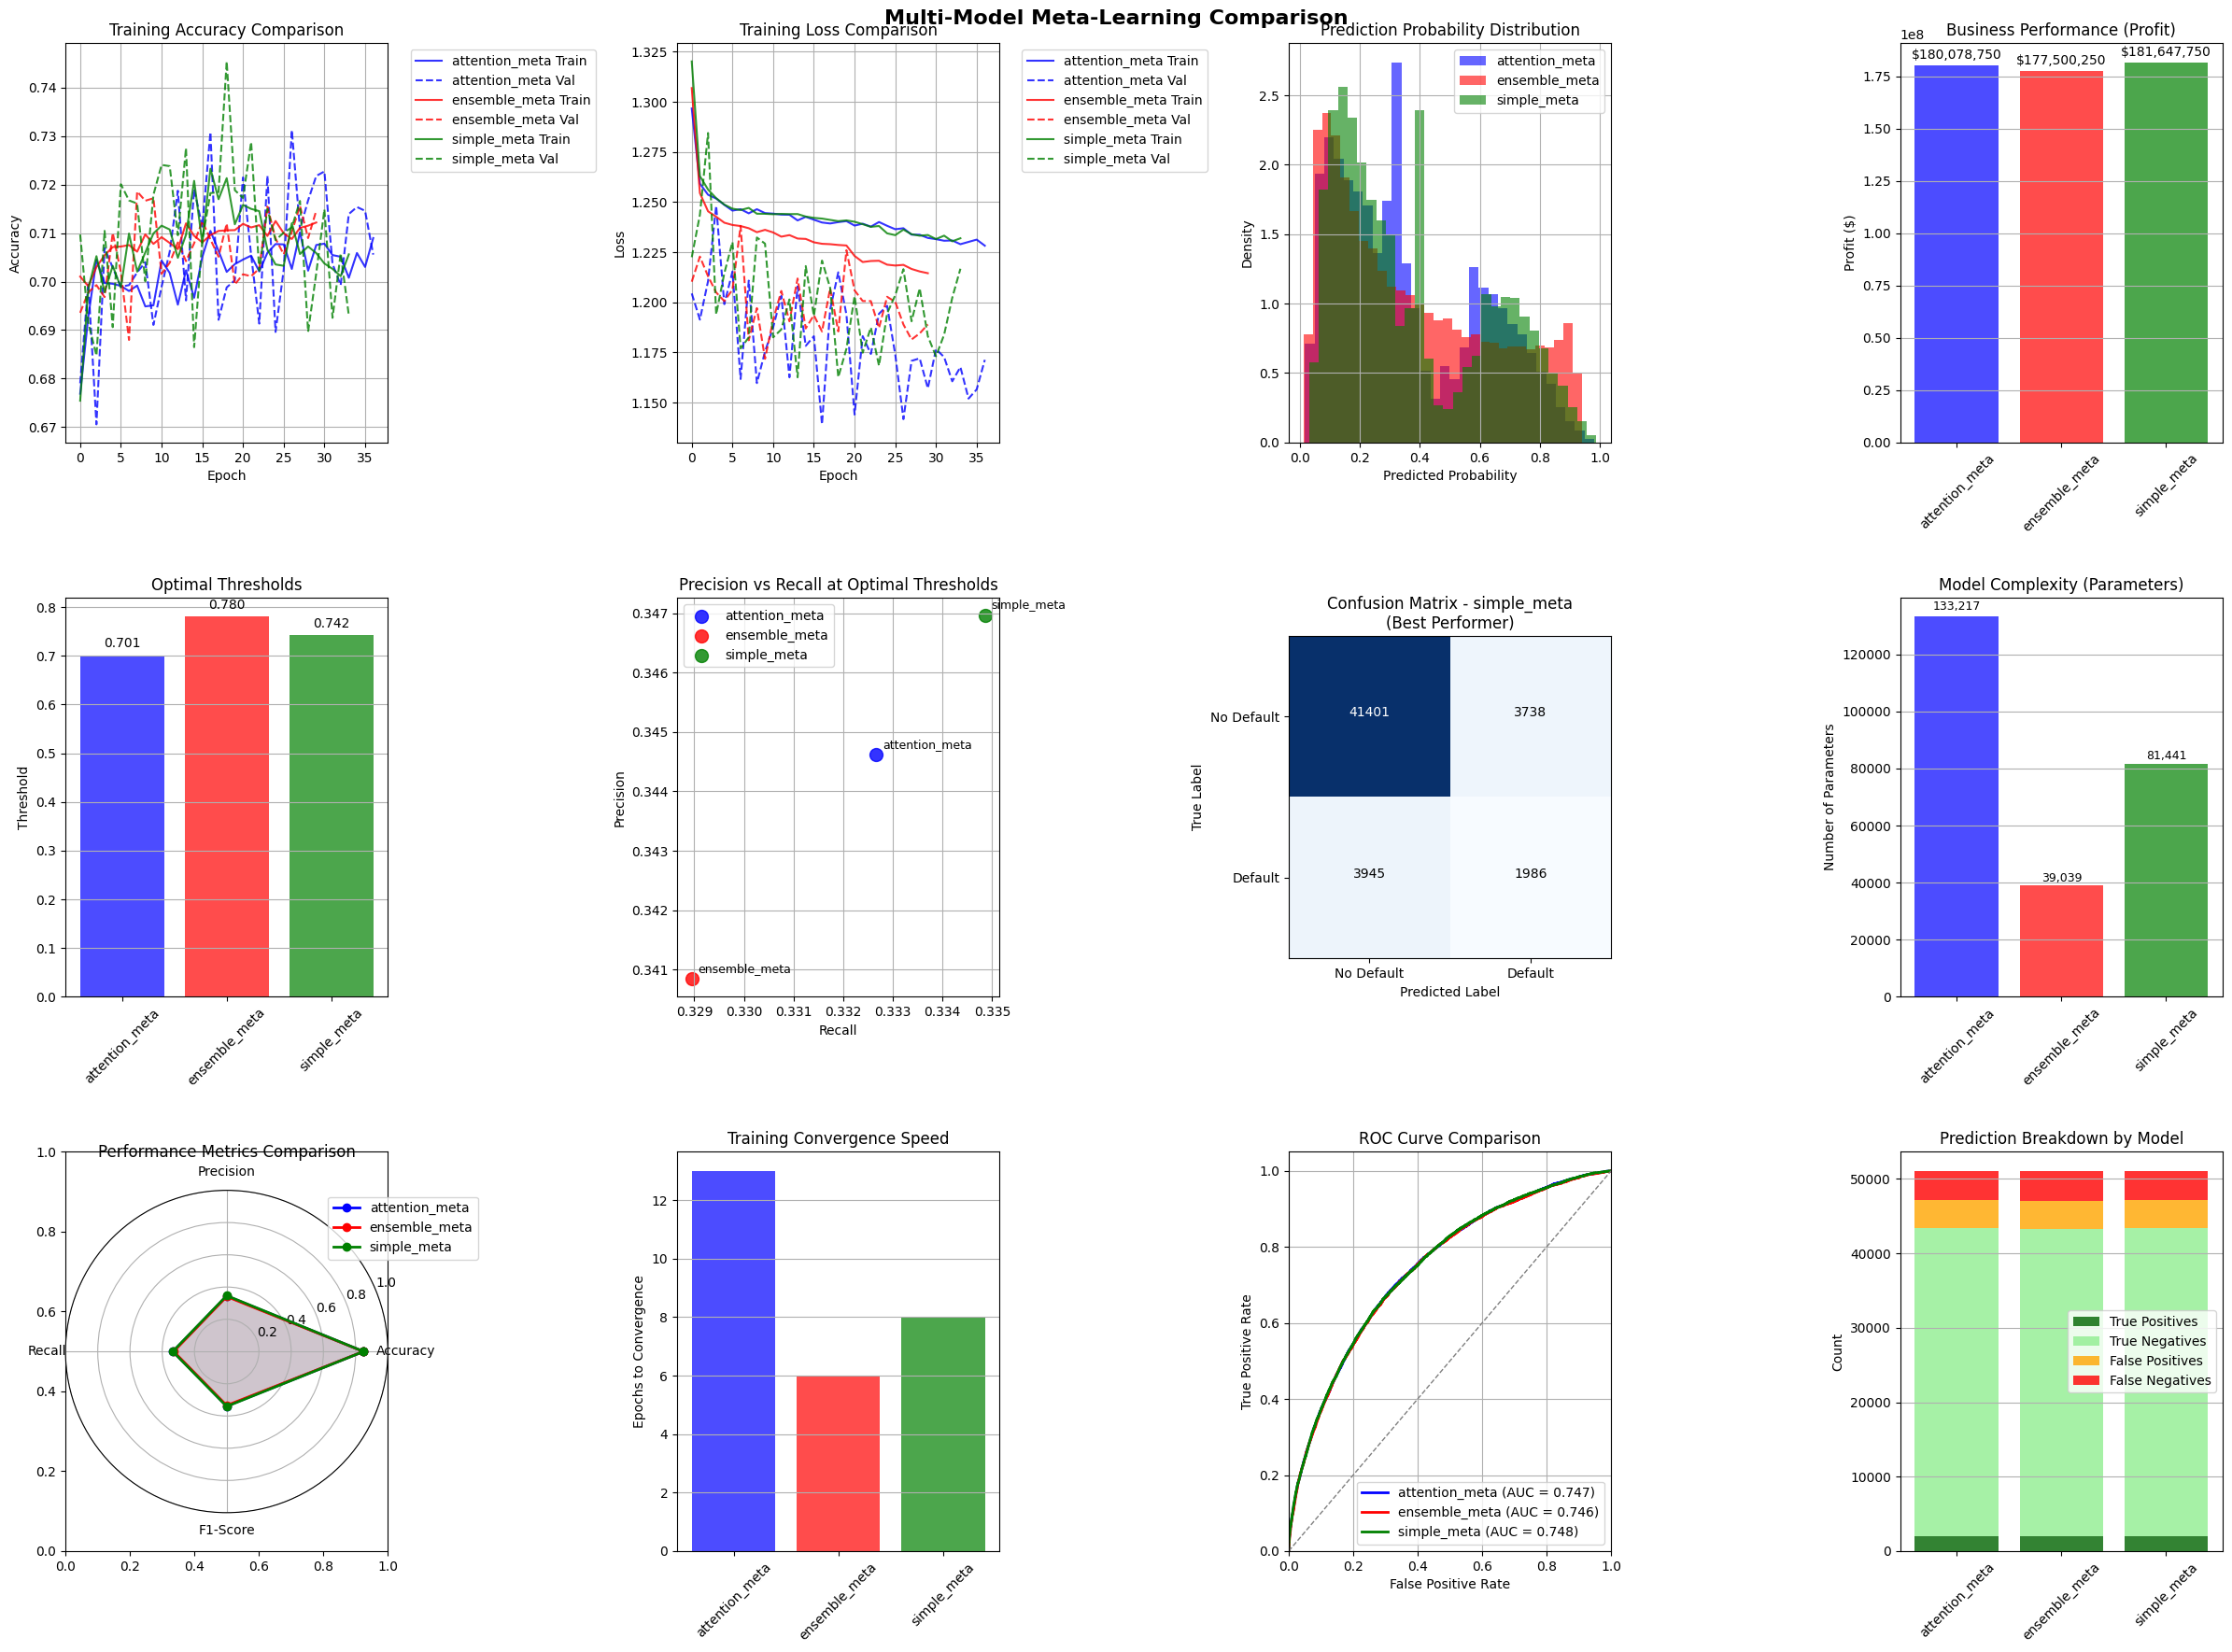

DETAILED MODEL COMPARISON REPORT

RANKING BY BUSINESS PERFORMANCE:                  
----------------------------------------------------------------------------------------------------
1. simple_meta          | Profit: $ 181,647,750 | Threshold: 0.7421
2. attention_meta       | Profit: $ 180,078,750 | Threshold: 0.7011
3. ensemble_meta        | Profit: $ 177,500,250 | Threshold: 0.7805

DETAILED METRICS COMPARISON:                      
----------------------------------------------------------------------------------------------------
Model                Accuracy   Precision    Recall     F1-Score   Parameters  
----------------------------------------------------------------------------------------------------
simple_meta          0.8496     0.3470       0.3349     0.3408     81,441      
attention_meta       0.8490     0.3446       0.3327     0.3385     133,217     
ensemble_meta        0.8482     0.3408       0.3289     0.3348     39,039      

CONFUSION MATRIX BREAKDOWN:        

In [15]:
analysis = comprehensive_model_analysis(results, y_test)